# Group connection test   
Next, we test bilateral symmetry by making an assumption that the left and the right
hemispheres both come from a stochastic block model, which models the probability
of any potential edge as a function of the groups that the source and target nodes
are part of.

For now, we use some broad cell type categorizations for each neuron to determine its
group. Alternatively, there are many methods for *estimating* these assignments to
groups for each neuron, which we do not explore here.

In [1]:
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.patches import PathPatch
from matplotlib.text import TextPath
from pkg.data import load_network_palette, load_unmatched
from pkg.io import FIG_PATH, get_environment_variables
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import (
    SmartSVG,
    draw_hypothesis_box,
    heatmap_grouped,
    make_sequential_colormap,
    networkplot_simple,
    plot_pvalues,
    plot_stochastic_block_probabilities,
    rainbowarrow,
    set_theme,
    svg_to_pdf,
)
from pkg.stats import stochastic_block_test
from pkg.utils import get_toy_palette, sample_toy_networks
from seaborn.utils import relative_luminance
from svgutils.compose import Figure, Panel, Text

from giskard.plot import merge_axes, rotate_labels, soft_axis_off
from graspologic.simulations import sbm

_, _, DISPLAY_FIGS = get_environment_variables()

FILENAME = "sbm_unmatched_test"

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "celltype_discrete"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

Environment variables:
   RESAVE_DATA: True
   RERUN_SIMS: False
   DISPLAY_FIGS: False



## The stochastic block model (SBM)
A [**stochastic block model (SBM)**
](https://en.wikipedia.org/wiki/Stochastic_block_model)
is a popular statistical model of networks. Put simply, this model treats the
probability of an edge occuring between node $i$ and node $j$ as purely a function of
the *communities* or *groups* that node $i$ and $j$ belong to. Therefore, this model
is parameterized by:

   1. An assignment of each node in the network to a group. Note that this assignment
      can be considered to be deterministic or random, depending on the specific
      framing of the model one wants to use.
   2. A set of group-to-group connection probabilities

```{admonition} Math
Let $n$ be the number of nodes, and $K$ be the number of groups in an SBM. For a
network $A$ sampled from an SBM:

$$ A \sim SBM(B, \tau)$$

We say that for all $(i,j), i \neq j$, with $i$ and $j$ both running
from $1 ... n$ the probability of edge $(i,j)$ occuring is:

$$ P[A_{ij} = 1] = P_{ij} = B_{\tau_i, \tau_j} $$

where $B \in [0,1]^{K \times K}$ is a matrix of group-to-group connection
probabilities and $\tau \in \{1...K\}^n$ is a vector of node-to-group assignments.
Note that here we are assuming $\tau$ is a fixed vector of assignments, though other
formuations of the SBM allow these assignments to themselves come from a categorical
distribution.
```

## Testing under the SBM model
Assuming this model, there are a few ways that one could test for differences between
two networks. In our case, we are interested in comparing the group-to-group
connection probability matrices, $B$,  for the left and right hemispheres.

````{admonition} Math
We are interested in testing:

```{math}
:label: sbm_unmatched_null
H_0: B^{(L)} = B^{(R)}, \quad H_A: B^{(L)} \neq B^{(R)}
```

````

Rather than having to compare one proportion as in [](er_unmatched_test.ipynb), we are
now interedted in comparing all $K^2$ probabilities between the SBM models for the
left and right hemispheres.

```{admonition} Math
The hypothesis test above can be decomposed into $K^2$ indpendent hypotheses.
$B^{(L)}$
and $B^{(R)}$ are both $K \times K$ matrices, where each element $b_{kl}$ represents
the probability of a connection from a neuron in group $k$ to one in group $l$. We
also know that group $k$ for the left network corresponds with group $k$ for the
right. In other words, the *groups* are matched. Thus, we are interested in testing,
for $k, l$ both running from $1...K$:

$$ H_0: B_{kl}^{(L)} = B_{kl}^{(R)},
\quad H_A: B_{kl}^{(L)} \neq B_{kl}^{(R)}$$

```

Thus, we will use
[Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) to
compare each set of probabilities. To combine these multiple hypotheses into one, we
will use [Fisher's method](https://en.wikipedia.org/wiki/Fisher%27s_method) for
combining p-values to give us a p-value for the overall test. We also can look at
the p-values for each of the individual tests after correction for multiple
comparisons by the
[Bonferroni-Holm method.
](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method)

For the current investigation, we focus on the case where $\tau$ is known ahead of
time, sometimes called the **A priori SBM**. We use some broad cell type labels which
were described in the paper which published the data to
define the group assignments $\tau$. Here, we do not explore
estimating these assignments, though many techniques exist for doing so. We note that
the results presented here could change depending on the group assignments which are
used. We also do not consider tests which would compare the assignment vectors,
$\tau$. {numref}`Figure {number} <fig:sbm_unmatched_test-group_counts>` shows the
number of neurons in each group in the group assignments $\tau$ for the left and
the right hemispheres. The number of neurons in each group is quite similar between
the two hemispheres.

In [2]:


np.random.seed(8888)
ps = [0.2, 0.4, 0.6]
n_steps = len(ps)
fig, axs = plt.subplots(
    3,
    n_steps,
    figsize=(6, 4),
    gridspec_kw=dict(height_ratios=[2, 2, 1], wspace=0),
    constrained_layout=True,
)


ns = [5, 6, 7]
B = np.array([[0.8, 0.2, 0.05], [0.05, 0.9, 0.2], [0.05, 0.05, 0.7]])
palette = get_toy_palette()


def label_matrix_element(
    matrix,
    row_ind,
    col_ind,
    label,
    ax,
    pad=0.02,
    fontsize="small",
    cmap=None,
    color=None,
    linewidth=2,
):
    xlow = col_ind + pad
    xhigh = col_ind + 1 - pad
    ylow = row_ind + pad
    yhigh = row_ind + 1 - pad
    ax.plot(
        [xlow, xhigh, xhigh, xlow, xlow],
        [yhigh, yhigh, ylow, ylow, yhigh],
        zorder=100,
        color="red",
        clip_on=False,
        linewidth=linewidth,
    )

    if color is None:
        if cmap is None:
            cmap = make_sequential_colormap("Blues", 0, 1)

        color = cmap(matrix[row_ind, col_ind])
        lum = relative_luminance(color)
        text_color = ".15" if lum > 0.408 else "w"
    else:
        text_color = color

    ax.text(
        col_ind + 0.5,
        row_ind + 0.5,
        label,
        ha="center",
        va="center",
        fontsize=fontsize,
        color=text_color,
    )


for i, p in enumerate(ps):
    B_mod = B.copy()
    B_mod[0, 1] = p
    seed = 8
    np.random.seed(seed)
    A, labels = sbm(ns, B_mod, directed=True, loops=False, return_labels=True)
    if i == 0:
        node_data = pd.DataFrame(index=np.arange(A.shape[0]))
        node_data["labels"] = labels + 1

    ax = axs[0, i]
    networkplot_simple(
        A, node_data, ax=ax, compute_layout=i == 0, palette=palette, group=True
    )
    ax.axis("square")
    ax.set(xticks=[], yticks=[], ylabel="", xlabel="")

    label_text = f"{p}"
    if i == 0:
        label_text = r"$B_{12} = $" + label_text
    ax.set_title(label_text)

    ax = axs[1, i]
    heatmap_grouped(B_mod, [1, 2, 3], palette=palette, ax=ax)
    label_matrix_element(B_mod, 0, 1, r"$B_{12}$", ax)


axs[0, 0].set_ylabel("Network", rotation=0, ha="right", labelpad=5)
axs[1, 0].set_ylabel(
    "Connection\nprobabilities\n" + r"($B$)",
    rotation=0,
    ha="right",
    va="center",
    labelpad=10,
)


ax = merge_axes(fig, axs, rows=2)


soft_axis_off(ax)
ax.set(xticks=[], yticks=[])

rainbowarrow(ax, (0.1, 0.5), (0.89, 0.5), cmap="Blues", lw=12)
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xlabel(r"Increasing $1 \rightarrow 2$ connection probability")

fig.set_facecolor("w")

gluefig("sbm_explain", fig)

In [3]:


fig, axs = plt.subplots(
    4,
    7,
    figsize=(14, 6),
    gridspec_kw=dict(
        wspace=0,
        hspace=0,
        height_ratios=[1.5, 5, 2.5, 5],
        width_ratios=[5, 2, 5, 2, 5, 1.5, 5],
    ),
    constrained_layout=False,
)

axs[0, 0].set_title("Group neurons", fontsize="medium")
axs[0, 2].set_title("Estimate group\nconnection probabilities", x=0.45, ha="center")
axs[0, 4].set_title("Compare probabilities,\ncompute p-values", fontsize="medium")
axs[0, 6].set_title("Combine p-values\nfor overall test", fontsize="medium")


A1, A2, node_data = sample_toy_networks()
palette = get_toy_palette()


ax = axs[1, 0]
networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)
ax.set_ylabel(
    "Left",
    color=network_palette["Left"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

ax = axs[3, 0]
networkplot_simple(A2, node_data, palette=palette, ax=ax, group=True)
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

ax = merge_axes(fig, axs, rows=None, cols=1)
ax.axis("off")
ax.plot([0.5, 0.5], [0, 1], color="lightgrey", linewidth=1.5)
ax.set_xlim((0, 1))

ax = axs[1, 2]
_, _, misc = stochastic_block_test(A1, A1, node_data["labels"], node_data["labels"])
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(
    Bhat1,
    [1, 2, 3],
    palette=palette,
    ax=ax,
)
top_ax.set_title(r"$\hat{B}^{(L)}$", color=network_palette["Left"])
left_ax.set_ylabel("Source group", fontsize="small")
ax.set_xlabel("Target group", fontsize="small")

label_matrix_element(Bhat1, 0, 1, r"$\hat{B}_{12}^{(L)}$", ax)


ax = axs[3, 2]
_, _, misc = stochastic_block_test(A2, A2, node_data["labels"], node_data["labels"])
Bhat2 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(Bhat2, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(r"$\hat{B}^{(R)}$", color=network_palette["Right"])
left_ax.set_ylabel("Source group", fontsize="small")
ax.set_xlabel("Target group", fontsize="small")
label_matrix_element(Bhat2, 0, 1, r"$\hat{B}_{12}^{(R)}$", ax)

# divider
ax = merge_axes(fig, axs, rows=None, cols=3)
ax.axis("off")
ax.plot([0.3, 0.3], [0, 1], color="lightgrey", linewidth=1.5, clip_on=False)
ax.set_xlim((0, 1))

# 3rd column
ax = merge_axes(fig, axs, rows=(1, 4), cols=4)


linestyle_kws = dict(linewidth=1, color="dimgrey")
xmin = 0.01
xmax = 0.99
ymax = 0.95
ymin = 0.65
ax.plot([xmin, xmax, xmax, xmin, xmin], [ymax, ymax, ymin, ymin, ymax], **linestyle_kws)

xstart = -0.05

ax.text(
    xstart - 0.05,
    0.9,
    r"$\hat{B}^{(L)}_{ij}$",
    ha="center",
    va="center",
    color=network_palette["Left"],
)

ax.text(
    xstart - 0.05,
    0.7,
    r"$\hat{B}^{(R)}_{ij}$",
    ha="center",
    va="center",
    color=network_palette["Right"],
)


def compare_probability_column(i, j, x, Bhat1, Bhat2, ax=None, palette=None):
    cmap = make_sequential_colormap("Blues")

    prob1 = Bhat1[i, j]
    prob2 = Bhat2[i, j]

    ystart = 1.07
    ax.plot(
        [x],
        [ystart],
        "o",
        markersize=9,
        markeredgecolor="black",
        markeredgewidth=1,
        markerfacecolor=palette[i + 1],
        clip_on=False,
    )
    ax.plot(
        [x],
        [ystart - 0.08],
        "o",
        markersize=9,
        markeredgecolor="black",
        markeredgewidth=1,
        markerfacecolor=palette[j + 1],
        clip_on=False,
    )
    ax.annotate(
        "",
        xy=(x, ystart - 0.08),
        xytext=(x, ystart),
        arrowprops=dict(
            arrowstyle="-|>",
            facecolor="black",
            shrinkA=5,
            shrinkB=4,
        ),
        clip_on=False,
        zorder=-1,
        fontsize=10,
    )

    ax.plot([x], [0.9], "s", markersize=15, color=cmap(prob1))
    ax.plot([x], [0.7], "s", markersize=15, color=cmap(prob2))
    ax.text(x, 0.78, r"$\overset{?}{=}$", fontsize="large", va="center", ha="center")

    ax.annotate(
        "",
        xy=(x, 0.53),
        xytext=(x, 0.63),
        arrowprops=dict(
            arrowstyle="-|>",
            facecolor="black",
        ),
    )

    p_text = r"$p_{"
    p_text += str(i + 1)
    p_text += str(j + 1)
    p_text += r"}$"
    ax.text(x, 0.47, p_text, fontsize="small", va="center", ha="center")
    ax.set(xticks=[], yticks=[])


compare_probability_column(0, 0, xstart + 0.15, Bhat1, Bhat2, ax=ax, palette=palette)
compare_probability_column(0, 1, xstart + 0.35, Bhat1, Bhat2, ax=ax, palette=palette)

ax.plot(
    [0.44], [0.78], ".", markersize=4, markeredgecolor="black", markerfacecolor="black"
)
ax.plot(
    [0.5], [0.78], ".", markersize=4, markeredgecolor="black", markerfacecolor="black"
)
ax.plot(
    [0.56], [0.78], ".", markersize=4, markeredgecolor="black", markerfacecolor="black"
)

compare_probability_column(2, 1, xstart + 0.75, Bhat1, Bhat2, ax=ax, palette=palette)
compare_probability_column(2, 2, xstart + 0.95, Bhat1, Bhat2, ax=ax, palette=palette)

xmin = 0.21
xmax = 0.39
ymax = 1.1
ymin = 0.4
ax.plot(
    [xmin, xmax, xmax, xmin, xmin],
    [ymax, ymax, ymin, ymin, ymax],
    color="red",
    clip_on=False,
    lw=1.5,
)

ax.set(xlim=(0, 1), ylim=(0, 1))


draw_hypothesis_box(
    "sbm", xstart + 0.1, 0.2, yskip=0.12, ax=ax, subscript=True, xpad=0.05, ypad=0.0075
)

ax.axis("off")

# divider
ax = merge_axes(fig, axs, rows=None, cols=5)
ax.axis("off")
ax.plot([0.65, 0.65], [0, 1], color="lightgrey", linewidth=1.5, clip_on=False)
ax.set_xlim((0, 1))

# last column
ax = axs[1, 6]
uncorrected_pvalues = np.array([[0.5, 0.1, 0.22], [0.2, 0.01, 0.86], [0.43, 0.2, 0.6]])
top_ax, left_ax = heatmap_grouped(
    uncorrected_pvalues,
    labels=[1, 2, 3],
    vmin=None,
    vmax=None,
    ax=ax,
    palette=palette,
    cmap="RdBu",
    center=1,
)
left_ax.set_ylabel("Source group", fontsize="small")
ax.set_xlabel("Target group", fontsize="small")
top_ax.set_title("p-values")

label_matrix_element(uncorrected_pvalues, 0, 1, r"$p_{12}$", ax, color="w")


ax = merge_axes(fig, axs, rows=(2, 4), cols=6)

# REF: https://stackoverflow.com/questions/50039667/matplotlib-scale-text-curly-brackets

x = 0.35
y = 0.9

trans = mtrans.Affine2D().rotate_deg_around(x, y, -90) + ax.transData
fp = FontProperties(weight="ultralight", stretch="ultra-condensed")
tp = TextPath((x, y), "$\}$", size=0.7, prop=fp, usetex=True)
pp = PathPatch(tp, lw=0, fc="k", transform=trans)
ax.add_artist(pp)
ax.set(xlim=(0, 1), ylim=(0, 1))


draw_hypothesis_box("sbm", 0.05, 0.4, yskip=0.15, ypad=0.02, ax=ax)

ax.axis("off")

for ax in axs.flat:
    if not ax.has_data():
        ax.axis("off")

fig.set_facecolor("w")
gluefig("sbm_methods_explain", fig)

In [4]:

set_theme(font_scale=1)

fig, axs = plt.subplots(
    1,
    2,
    figsize=(6, 3),
    gridspec_kw=dict(
        wspace=0.3,
    ),
    constrained_layout=True,
)

ax = axs[0]
node_data = networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)
centroids = node_data.groupby("labels").mean()
ax.annotate(
    "",
    xy=centroids.loc[2],
    xytext=centroids.loc[1],
    arrowprops=dict(arrowstyle="-|>", linewidth=4, color="red"),
)
ax.set_title("Group neurons", pad=10)
ax.autoscale(False)
ax.plot([1.15, 1.15], [-1, 1], color="lightgrey", linewidth=1.5, clip_on=False)

ax = axs[1]
top_ax, left_ax = heatmap_grouped(
    Bhat1,
    [1, 2, 3],
    palette=palette,
    ax=ax,
    xlabel_loc="top",
)
top_ax.set_title(
    "Estimate group-to-group\nconnection probabilities " + r"($\hat{B}$)", pad=10
)
left_ax.set_ylabel("Source group", fontsize="medium")
ax.set_xlabel("Target group", fontsize="medium")

label_matrix_element(
    Bhat1,
    0,
    1,
    r"$\hat{B}_{12}$",
    ax,
    fontsize="medium",
    pad=0.03,
    linewidth=3,
)

fig.set_facecolor("w")

gluefig("sbm_simple_methods", fig)

In [5]:

stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
)
glue("pvalue", pvalue, form="pvalue")
n_tests = misc["n_tests"]
glue("n_tests", n_tests)
print(pvalue)

3.2645011493987496e-08


In [6]:


def get_significant_pairs(df):
    row_indices, col_indices = np.nonzero(df.values)
    row_indices = df.index[row_indices]
    col_indices = df.columns[col_indices]
    return list(zip(row_indices, col_indices))


significant_pairs = get_significant_pairs(misc["rejections"])

n_significant_pairs = len(significant_pairs)
glue("n_significant_pairs", n_significant_pairs, form="intword")

print("Significant pairs:\n", significant_pairs)

Significant pairs:
 [('KC', 'KC'), ('LHN', 'Other'), ('Other', 'LHN'), ('Other', 'Other'), ('PN', 'LHN'), ('PN$^{\\mathrm{Somato}}$', 'Other'), ('PN$^{\\mathrm{Somato}}$', 'PN$^{\\mathrm{Somato}}$')]


In [7]:

set_theme(font_scale=1)


def melt(misc, names):
    # TODO should be a better way with melt?

    if isinstance(names, str):
        names = [names]
    df = misc[names[0]]
    row_inds, col_inds = np.indices(df.shape)
    row_inds = row_inds.ravel()
    col_inds = col_inds.ravel()
    row_index = df.index[row_inds].to_series().reset_index(drop=True)
    col_index = df.index[col_inds].to_series().reset_index(drop=True)
    col_index.name = "target"
    series_list = [row_index, col_index]
    for name in names:
        df = misc[name]
        values = pd.Series(df.values.ravel(), name=name)
        series_list.append(values)
    melted_df = pd.concat(series_list, axis=1)
    return melted_df


melted_df = melt(
    misc,
    [
        "probabilities1",
        "probabilities2",
        "possible1",
        "possible2",
        "uncorrected_pvalues",
    ],
)
melted_df["Sample size"] = melted_df["possible1"] + melted_df["possible2"]
melted_df["log10(p-value)"] = np.log10(melted_df["uncorrected_pvalues"])

melted_df = melted_df[~melted_df["log10(p-value)"].isna()]


vmax = 0
vmin = melted_df["log10(p-value)"].min()
center = 0
cmap = mpl.cm.get_cmap("RdBu")
vrange = max(vmax - center, center - vmin)
normlize = mpl.colors.Normalize(center - vrange, center + vrange)
cmin, cmax = normlize([vmin, vmax])
cc = np.linspace(cmin, cmax, 256)
cmap = mpl.colors.ListedColormap(cmap(cc))

hb_thresh = 0.05 / misc["n_tests"]
significant = misc["uncorrected_pvalues"] < hb_thresh
row_inds, col_inds = np.nonzero(significant.values)
row_index = significant.index[row_inds]
col_index = significant.columns[col_inds]
sig_df = melted_df.set_index(["source", "target"]).loc[zip(row_index, col_index)]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax = axs[0]
sns.scatterplot(
    data=melted_df,
    x="probabilities2",
    y="probabilities1",
    size="Sample size",
    hue="log10(p-value)",
    palette=cmap,
    sizes=(10, 100),
    ax=ax,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set(xlabel="Right probability", ylabel="Left probability")
ax.plot([0.00001, 1], [0.00001, 1], color="grey", zorder=-2)

for i, row in sig_df.iterrows():
    ax.annotate(
        "",
        (row["probabilities2"], row["probabilities1"]),
        xytext=(25, -25),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
        ha="center",
        va="center",
        zorder=-1,
    )


ax = axs[1]
sns.scatterplot(
    data=melted_df,
    x="probabilities2",
    y="probabilities1",
    size="Sample size",
    hue="log10(p-value)",
    palette=cmap,
    sizes=(10, 100),
    ax=ax,
    legend=False,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set(xlabel="Right probability", ylabel="")
ax.plot([0.00001, 1], [0.00001, 1], color="grey", zorder=-2)

for i, row in sig_df.iterrows():
    ax.annotate(
        "",
        (row["probabilities2"], row["probabilities1"]),
        xytext=(25, -25),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
        ha="center",
        va="center",
        zorder=-1,
    )
ax.set(
    xlim=(1e-2, 1),
    ylim=(1e-2, 1),
)

gluefig("probs_scatter", fig)

In [8]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

group_counts_left = misc["group_counts1"]
group_counts_right = misc["group_counts2"]

for i in range(len(group_counts_left)):
    ax.bar(
        i - 0.17,
        group_counts_left[i],
        width=0.3,
        color=network_palette["Left"],
        label="Left" if i == 0 else None,
    )
    ax.bar(
        i + 0.17,
        group_counts_right[i],
        width=0.3,
        color=network_palette["Right"],
        label="Right" if i == 0 else None,
    )

rotate_labels(ax)
ax.set(
    ylabel="Count",
    xlabel="Group",
    xticks=np.arange(len(group_counts_left)) + 0.2,
    xticklabels=group_counts_left.index,
)
ax.legend(title="Hemisphere", loc="upper left", frameon=True)
gluefig("group_counts", fig)


```{glue:figure} fig:sbm_unmatched_test-group_counts
:name: "fig:sbm_unmatched_test-group_counts"

The number of neurons in each group in each hemisphere. Note the similarity between
the hemispheres.
```

In [9]:

fig, axs = plot_stochastic_block_probabilities(misc, network_palette)

gluefig("sbm_uncorrected", fig)

In [10]:

# need to save this for later for setting colorbar the same on other plot
pvalue_vmin = np.log10(np.nanmin(misc["corrected_pvalues"].values))
glue("pvalue_vmin", pvalue_vmin)

plot_pvalues(
    misc,
    pvalue_vmin,
    annot_missing=True,
)
gluefig("sbm_uncorrected_pvalues", fig)

plot_pvalues(
    misc,
    pvalue_vmin,
    annot_missing=False,
)
gluefig("sbm_uncorrected_pvalues_unlabeled", fig)

Next, we run the test for bilateral symmetry under the stochastic block model.
{numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>` shows both the
estimated group-to-group probability matrices, $\hat{B}^{(L)}$ and $\hat{B}^{(R)}$,
as well as the p-values from each test comparing each element of these matrices. From
a visual comparison of $\hat{B}^{(L)}$ and $\hat{B}^{(R)}$
{numref}`(Figure {number} A) <fig:sbm_unmatched_test-sbm_uncorrected>`, we see that
the
group-to-group connection probabilities are qualitatively similar. Note also that some
group-to-group connection probabilities are zero, making it non-sensical to do a
comparision of binomial proportions. We highlight these elements in the $\hat{B}$
matrices with an explicit "0", noting that we did not run the corresponding test in
these cases.

In {numref}`Figure {number} B <fig:sbm_unmatched_test-sbm_uncorrected>`, we see the
p-values from all {glue:text}`sbm_unmatched_test-n_tests` that were run. After
Bonferroni-Holm correction, 5 tests yield p-values less than 0.05, indicating that
we reject the null hypothesis that those elements of the $\hat{B}$ matrices are the
same between the two hemispheres. We also combine all p-values using Fisher's method,
which yields an overall p-value for the entire null hypothesis in
Equation {eq}`sbm_unmatched_null` of
{glue:text}`sbm_unmatched_test-uncorrected_pvalue:0.2e`.

```{glue:figure} fig:sbm_unmatched_test-sbm_uncorrected
:name: "fig:sbm_unmatched_test-sbm_uncorrected"

Comparison of stochastic block model fits for the left and right hemispheres.
**A)** The estimated group-to-group connection probabilities for the left
and right hemispheres appear qualitatively similar. Any estimated
probabilities which are zero (i.e. no edge was present between a given pair of
communities) is indicated explicitly with a "0" in that cell of the matrix.
**B)** The p-values for each hypothesis test between individual elements of
the block probability matrices. In other words, each cell represents a test for
whether a given group-to-group connection probability is the same on the left and the
right sides. "X" denotes a significant p-value after Bonferroni-Holm correction,
with $\alpha=0.05$. "B" indicates that a test was not run since the estimated
probability
was zero in that cell on both the left and right. "L" indicates this was the case on
the left only, and "R" that it was the case on the right only. These individual
p-values were combined using Fisher's method, resulting in an overall p-value (for the
null hypothesis that the two group connection probability matrices are the same) of
{glue:text}`sbm_unmatched_test-uncorrected_pvalue:0.2e`.
```

## Adjusting for a difference in density
From {numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>`, we see that
we have sufficient evidence to reject
the null hypothesis of bilateral symmetry under this version of the SBM. However,
we already saw in [](er_unmatched_test) that the overall
densities between the two networks are different. Could it be that this rejection of
the null hypothesis under the SBM can be explained purely by this difference in
density? In other words, are the group-to-group connection probabilities on the right
simply a "scaled up" version of those on the right, where each probability is scaled
by the same amount?

In {numref}`Figure {number} <fig:sbm_unmatched_test-probs_uncorrected>`,
we plot the estimated
probabilities on the left and the right hemispheres (i.e. each element of $\hat{B}$),
as
well as the difference between them. While subtle, we note that there is a slight
tendency for the left hemisphere estimated probability to be lower than the
corresponding one on the right. Specifically, we can also look at the group-to-group
connection probabilities which were significantly different in
{numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>` - these are plotted
in {numref}`Figure {number} <fig:sbm_unmatched_test-significant_p_comparison>`. Note
that in every case, the estimated probability on the right is higher with that on the
right.


In [11]:


def plot_estimated_probabilities(misc):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_ratio"]
    B2 = B2 * null_odds
    B1_ravel = B1.values.ravel()
    B2_ravel = B2.values.ravel()
    arange = np.arange(len(B1_ravel))
    sum_ravel = B1_ravel + B2_ravel
    sort_inds = np.argsort(-sum_ravel)
    B1_ravel = B1_ravel[sort_inds]
    B2_ravel = B2_ravel[sort_inds]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax = axs[0]
    sns.scatterplot(
        x=arange,
        y=B1_ravel,
        color=network_palette["Left"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
    )
    sns.scatterplot(
        x=arange,
        y=B2_ravel,
        color=network_palette["Right"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
        zorder=-1,
    )
    ax.text(
        0.7,
        0.8,
        "Left",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    ax.text(
        0.7,
        0.7,
        "Right",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set(
        ylabel="Estimated probability " + r"($\hat{p}$)",
        xticks=[],
        xlabel="Sorted group pairs",
    )
    ax.spines["bottom"].set_visible(False)

    ax = axs[1]
    diff = B1_ravel - B2_ravel
    yscale = np.max(np.abs(diff))
    yscale *= 1.05
    sns.scatterplot(
        x=arange, y=diff, ax=ax, linewidth=0, s=25, color=neutral_color, alpha=1
    )
    ax.axhline(0, color="black", zorder=-1)
    ax.spines["bottom"].set_visible(False)
    ax.set(
        xticks=[],
        ylabel=r"$\hat{p}_{left} - \hat{p}_{right}$",
        xlabel="Sorted group pairs",
        ylim=(-yscale, yscale),
    )
    n_greater = np.count_nonzero(diff > 0)
    n_total = len(diff)
    ax.text(
        0.3,
        0.8,
        f"Left connection stronger ({n_greater}/{n_total})",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    n_lesser = np.count_nonzero(diff < 0)
    ax.text(
        0.3,
        0.15,
        f"Right connection stronger ({n_lesser}/{n_total})",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )

    fig.text(0.02, 0.905, "A)", fontweight="bold", fontsize=30)
    fig.text(0.02, 0.49, "B)", fontweight="bold", fontsize=30)

    return fig, ax


fig, ax = plot_estimated_probabilities(misc)
gluefig("probs_uncorrected", fig)

```{glue:figure} fig:sbm_unmatched_test-probs_uncorrected
:name: "fig:sbm_unmatched_test-probs_uncorrected"

Comparison of estimated connection probabilities for the left and right hemispheres.
**A)** The estimated group-to-group connection probabilities ($\hat{p}$), sorted by
the mean left/right connection probability. Note the very subtle tendency for the
left probability to be lower than the corresponding one on the right. **B)** The
differences between corresponding group-to-group connection probabilities
($\hat{p}^{(L)} - \hat{p}^{(R)}$). The trend of the left connection probabilities
being slightly smaller than the corresponding probability on the right is more
apparent here, as there are more negative than positive values.
```

In [12]:


def plot_significant_probabilities(misc):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_ratio"]
    B2 = B2 * null_odds
    index = B1.index
    uncorrected_pvalues = misc["uncorrected_pvalues"]
    n_tests = misc["n_tests"]

    alpha = 0.05
    hb_thresh = alpha / n_tests
    significant = uncorrected_pvalues < hb_thresh

    row_inds, col_inds = np.nonzero(significant.values)

    rows = []
    for row_ind, col_ind in zip(row_inds, col_inds):
        source = index[row_ind]
        target = index[col_ind]
        left_p = B1.loc[source, target]
        right_p = B2.loc[source, target]
        pair = source + r"$\rightarrow$" + "\n" + target
        rows.append(
            {
                "source": source,
                "target": target,
                "p": left_p,
                "side": "Left",
                "pair": pair,
            }
        )
        rows.append(
            {
                "source": source,
                "target": target,
                "p": right_p,
                "side": "Right",
                "pair": pair,
            }
        )
    sig_data = pd.DataFrame(rows)

    mean_ps = sig_data.groupby("pair")["p"].mean()
    pair_orders = mean_ps.sort_values(ascending=False).index

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    sns.pointplot(
        data=sig_data,
        y="p",
        x="pair",
        ax=ax,
        hue="side",
        hue_order=["Right", "Left"],
        order=pair_orders,
        dodge=False,
        join=False,
        palette=network_palette,
        markers="_",
        scale=1.75,
    )
    ax.tick_params(axis="x", length=7)

    ax.set_yscale("log")
    ax.set_ylim((0.01, 1))

    leg = ax.get_legend()
    leg.set_title("Hemisphere")
    leg.set_frame_on(True)
    rotate_labels(ax)
    ax.set(xlabel="Group pair", ylabel="Connection probability")
    return fig, ax


fig, ax = plot_significant_probabilities(misc)
gluefig("significant_p_comparison", fig)

/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9882352941176471, 0.5529411764705883, 0.3843137254901961)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.4, 0.7607843137254902, 0.6470588235294118)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


```{glue:figure} fig:sbm_unmatched_test-significant_p_comparison
:name: "fig:sbm_unmatched_test-significant_p_comparison"

Comparison of estimated group-to-group connection probabilities for the group-pairs
which were significantly different in
{numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>`.
In each case, the connection probability on the right hemisphere is higher.
```

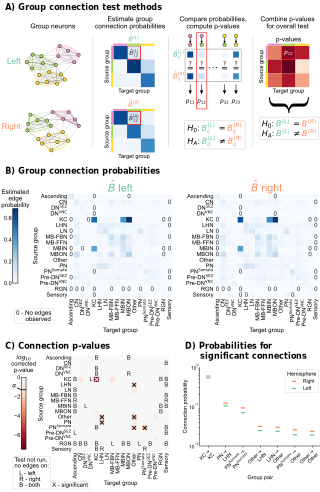

In [13]:

fontsize = 8

methods = SmartSVG(FIG_PATH / "sbm_methods_explain.svg")
methods.set_width(400)
methods.move(0, 15)
methods_panel = Panel(
    methods,
    Text("A) Group connection test methods", 5, 10, size=fontsize, weight="bold"),
)

probs = SmartSVG(FIG_PATH / "sbm_uncorrected.svg")
probs.set_width(400)
probs.move(0, 15)
probs_panel = Panel(
    probs,
    Text(
        "B) Group connection probabilities",
        5,
        10,
        size=fontsize,
        weight="bold",
    ),
)
probs_panel.move(0, methods.height * 0.9)

pvalues = SmartSVG(FIG_PATH / "sbm_uncorrected_pvalues.svg")
pvalues.set_width(200)
pvalues.move(10, 15)
pvalues_panel = Panel(
    pvalues, Text("C) Connection p-values", 5, 10, size=fontsize, weight="bold")
)
pvalues_panel.move(0, (methods.height + probs.height) * 0.9)

comparison = SmartSVG(FIG_PATH / "significant_p_comparison.svg")
comparison.set_width(175)
comparison.move(2, 25)
comparison_panel = Panel(
    comparison,
    Text("D) Probabilities for", 5, 10, size=fontsize, weight="bold"),
    Text("significant connections", 20, 20, size=fontsize, weight="bold"),
)
comparison_panel.move(pvalues.width * 0.9, (methods.height + probs.height) * 0.9)

fig = Figure(
    methods.width * 0.8,
    (methods.height + probs.height + pvalues.height) * 0.9,
    methods_panel,
    probs_panel,
    pvalues_panel,
    comparison_panel,
)

fig.save(FIG_PATH / "sbm_uncorrected_composite.svg")

svg_to_pdf(
    FIG_PATH / "sbm_uncorrected_composite.svg",
    FIG_PATH / "sbm_uncorrected_composite.pdf",
)

fig

## End

In [14]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:38.425665
Completed at 2023-03-08 12:40:46.817001
